# 0. Environment Setup

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading and Initial Inspection

In [17]:
# df = pd.read_excel("../data/Coffee Shop Sales.xlsx", engine='openpyxl')
# df.to_csv('../data/Coffee Shop Sales.csv', index=False)
df = pd.read_csv("../data/Coffee Shop Sales.csv")
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [18]:
print(df.shape)
print(df.isnull().sum())

(149116, 11)
transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64


# 2. Data Cleaning and Feature Engineering

In [19]:
# Create a new column for total trasaction value (sales)
df["sales"] = df["transaction_qty"] * df["unit_price"]

# I convert the time column to string first to ensure consistency, then calculate hour
df["transaction_hour"] = (
    df["transaction_time"].astype(str).str.split(":").str[0].astype(int)
)
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["Month_Year"] = df["transaction_date"].dt.to_period("M")
df["transaction_month"] = df["transaction_date"].dt.month
# [Data Cleaning Step] Constructing the Real Basket ID

df["basket_id"] = (
    df["store_id"].astype(str)
    + "_"
    + df["transaction_date"].astype(str)
    + "_"
    + df["transaction_time"].astype(str)
)

df[["transaction_hour", "transaction_date", "transaction_month", "basket_id"]]

,transaction_hour,transaction_date,transaction_month,basket_id
0,7,2023-01-01,1,5_2023-01-01_07:06:11
1,7,2023-01-01,1,5_2023-01-01_07:08:56
2,7,2023-01-01,1,5_2023-01-01_07:14:04
3,7,2023-01-01,1,5_2023-01-01_07:20:24
4,7,2023-01-01,1,5_2023-01-01_07:22:41
...,...,...,...,...
149111,20,2023-06-30,6,8_2023-06-30_20:18:41
149112,20,2023-06-30,6,8_2023-06-30_20:25:10
149113,20,2023-06-30,6,8_2023-06-30_20:31:34
149114,20,2023-06-30,6,8_2023-06-30_20:57:19


# 3. Pricing Structure & Outlier Exploration

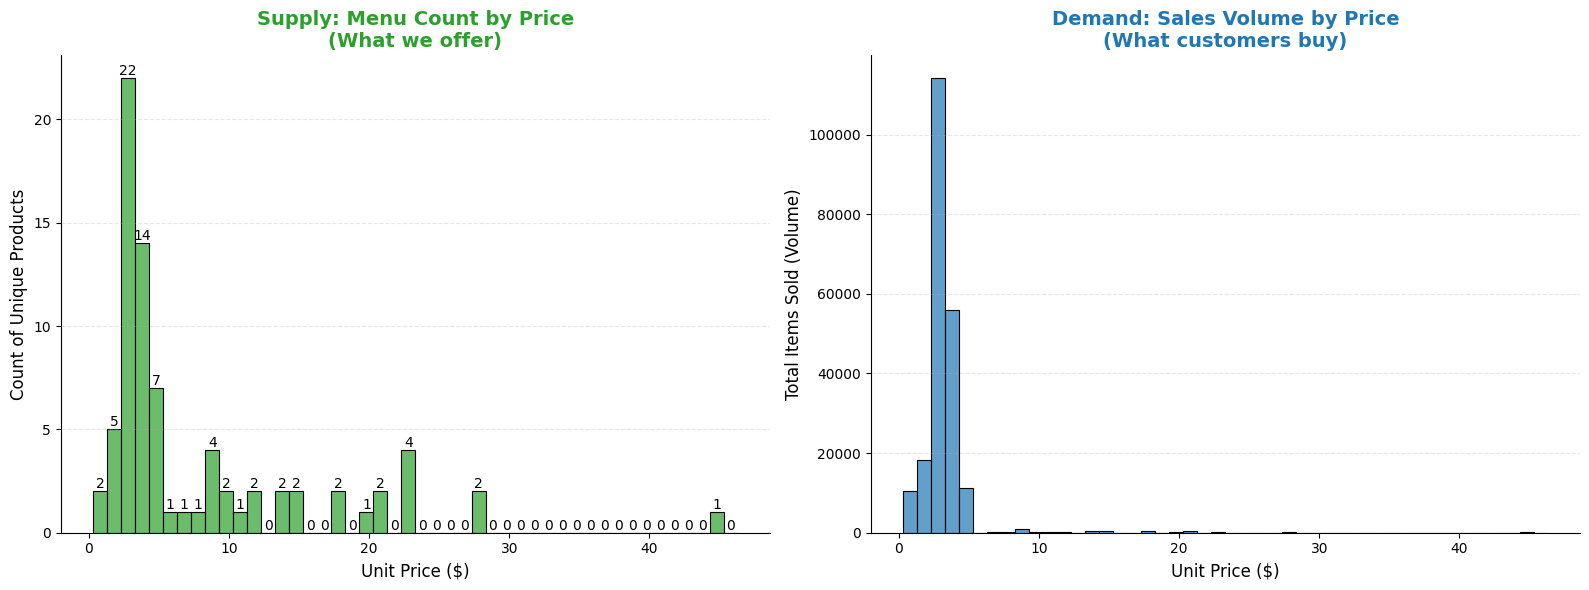

In [20]:
# 1. Prepare Data
# Supply Data: Unique Menu Items only
menu_df = df[["product_type", "unit_price"]].drop_duplicates()

# 2. Setup Canvas (1 Row, 2 Columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# --- Plot 1: Supply (Left Side) ---
# "What we offer"
sns.histplot(
    data=menu_df,
    x="unit_price",
    discrete=True,
    color="#2ca02c",  # Green for Supply
    alpha=0.7,
    ax=axes[0],  # Draw on the left subplot
)
axes[0].set_title(
    "Supply: Menu Count by Price\n(What we offer)",
    fontsize=14,
    fontweight="bold",
    color="#2ca02c",
)
axes[0].set_ylabel("Count of Unique Products", fontsize=12)
axes[0].set_xlabel("Unit Price ($)", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.3)

# Add value labels for Supply
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=10)

# --- Plot 2: Demand (Right Side) ---
# "What customers buy"
sns.histplot(
    data=df,
    x="unit_price",
    weights="transaction_qty",  # Weight by quantity sold
    discrete=True,
    color="#1f77b4",  # Blue for Demand
    alpha=0.7,
    ax=axes[1],  # Draw on the right subplot
)
axes[1].set_title(
    "Demand: Sales Volume by Price\n(What customers buy)",
    fontsize=14,
    fontweight="bold",
    color="#1f77b4",
)
axes[1].set_ylabel("Total Items Sold (Volume)", fontsize=12)
axes[1].set_xlabel("Unit Price ($)", fontsize=12)
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

# 3. Final Polish
sns.despine()
plt.tight_layout()
plt.show()

In [21]:
# [Analysis: Supply vs. Demand by $1 Price Bins]

# 1. Create $1 Price Bins (0-1, 1-2, ..., 9-10, 10+)
# ---------------------------------------------------------
bins = range(0, 12)  # 0, 1, 2 ... 11
labels = [f"${i}-${i+1}" for i in range(0, 10)] + ["$10+"]

# Create a new column 'price_bin'
df["price_bin"] = pd.cut(df["unit_price"], bins=bins, labels=labels, right=False)


# 2. Analyze Green Peak (Supply/Menu Side)
# ---------------------------------------------------------
# Count unique products in each bin
supply_bin_counts = df.groupby("price_bin", observed=False)["product_type"].nunique()

# Find the Peak Bin
green_peak_bin = supply_bin_counts.idxmax()
green_peak_count = supply_bin_counts.max()

# List products in this bin
green_peak_products = df[df["price_bin"] == green_peak_bin]["product_type"].unique()


# 3. Analyze Blue Peak (Demand/Sales Side)
# ---------------------------------------------------------
# Sum quantity sold in each bin
demand_bin_counts = df.groupby("price_bin", observed=False)["transaction_qty"].sum()

# Find the Peak Bin
blue_peak_bin = demand_bin_counts.idxmax()
blue_peak_volume = demand_bin_counts.max()

# Top sellers in this bin
blue_peak_top_items = (
    df[df["price_bin"] == blue_peak_bin]
    .groupby("product_type")["transaction_qty"]
    .sum()
    .nlargest(3)
)


# 4. Print Results
# ---------------------------------------------------------
print("=" * 50)
print("🟢 GREEN PEAK (Menu Focus)")
print(f"You offer the most variety in range: [{green_peak_bin}]")
print("=" * 50)
print(f"Product Count : {green_peak_count} unique items")
print(
    f"Typical Items : {', '.join(green_peak_products[:5])}..."
)  # Show first 5 to avoid clutter


print("\n" + "=" * 50)
print("🔵 BLUE PEAK (Customer Wallet)")
print(f"Customers buy the most volume in range: [{blue_peak_bin}]")
print("=" * 50)
print(f"Total Volume  : {blue_peak_volume:,.0f} items sold")
print(f"Top Drivers   :")
for product, qty in blue_peak_top_items.items():
    print(f"  - {product:<20}: {qty:,.0f} sold")

# 5. Mismatch Check
print("\n" + "-" * 50)
if green_peak_bin == blue_peak_bin:
    print("✅ PERFECT MATCH: Your menu structure fits customer spending habits.")
else:
    print(f"⚠️ MISMATCH DETECTED:")
    print(f"   -> You focused your menu on {green_peak_bin},")
    print(f"   -> But customers are heavily buying in {blue_peak_bin}.")
print("-" * 50)

🟢 GREEN PEAK (Menu Focus)
You offer the most variety in range: [$3-$4]
Product Count : 13 unique items
Typical Items : Gourmet brewed coffee, Brewed Chai tea, Scone, Hot chocolate, Brewed Black tea...

🔵 BLUE PEAK (Customer Wallet)
Customers buy the most volume in range: [$3-$4]
Total Volume  : 107,999 items sold
Top Drivers   :
  - Barista Espresso    : 15,313 sold
  - Gourmet brewed coffee: 12,815 sold
  - Organic brewed coffee: 8,702 sold

--------------------------------------------------
✅ PERFECT MATCH: Your menu structure fits customer spending habits.
--------------------------------------------------


In [22]:
# Unique combinations of product_detail and unit_price

df[["product_detail", "unit_price"]].drop_duplicates().sort_values("product_detail")

,product_detail,unit_price
88852,Almond Croissant,4.69
102,Almond Croissant,3.75
3451,Brazilian - Organic,18.00
32,Brazilian Lg,3.50
31,Brazilian Rg,3.00
...,...,...
19,Sustainably Grown Organic Lg,4.75
41,Sustainably Grown Organic Rg,3.75
3896,Traditional Blend Chai,8.95
60,Traditional Blend Chai Lg,3.00


There are only 80 product detail (80 kinds of product), but there are 98 prices in total. There are 18 extra prices.

In [23]:
# 1. 找出每个商品有几个“不同的价格”
# 也就是你说的：先由 product 和 price 组合，然后数数
product_pricing = df.groupby("product_detail")["unit_price"].unique()

# 2. 筛选出那些“不老实”的（价格数量 > 1 的商品）
# 这些就是导致 80 变成 98 的原因
multi_priced_items = product_pricing[product_pricing.apply(len) > 1]

print(f"📊 Price Variance Report:")
print(f"-------------------------")
print(f"Total Products Checked : {len(product_pricing)}")
print(f"Products with >1 Price : {len(multi_priced_items)} (Expected ~18)")
print(f"-------------------------\n")

print("📋 The 'Hidden Size' Detective:")
print("(These products depend on size/location for pricing)")

# 3. 打印详情
for product, prices in multi_priced_items.items():
    # 排序，从小到大显示，方便看出是不是 $0.5 的升杯差价
    sorted_prices = sorted(prices)

    # 算出差价 (Gap)
    gap = sorted_prices[-1] - sorted_prices[0]

    price_str = ", ".join([f"${p:.2f}" for p in sorted_prices])
    print(f"🔹 {product:<25} : {price_str} \t(Gap: ${gap:.2f})")

# 4. 验证是否是“地点”造成的 (Location Check)
# 挑出第一个多价商品，看看它的价格分布是否跟门店有关
if len(multi_priced_items) > 0:
    target_product = multi_priced_items.index[0]
    print(f"\n🌍 Location Check for [{target_product}]:")
    # 交叉表：看每个门店卖这个商品是卖哪个价格
    loc_check = pd.crosstab(
        df[df["product_detail"] == target_product]["store_location"],
        df[df["product_detail"] == target_product]["unit_price"],
    )
    print(loc_check)

📊 Price Variance Report:
-------------------------
Total Products Checked : 80
Products with >1 Price : 15 (Expected ~18)
-------------------------

📋 The 'Hidden Size' Detective:
(These products depend on size/location for pricing)
🔹 Almond Croissant          : $3.75, $4.69 	(Gap: $0.94)
🔹 Chocolate Chip Biscotti   : $3.50, $4.38 	(Gap: $0.88)
🔹 Chocolate Croissant       : $3.75, $4.69 	(Gap: $0.94)
🔹 Cranberry Scone           : $3.25, $4.06 	(Gap: $0.81)
🔹 Croissant                 : $3.50, $4.38 	(Gap: $0.88)
🔹 Ginger Biscotti           : $3.50, $4.38 	(Gap: $0.88)
🔹 Ginger Scone              : $2.65, $3.25, $4.06 	(Gap: $1.41)
🔹 Hazelnut Biscotti         : $3.25, $4.06 	(Gap: $0.81)
🔹 I Need My Bean! Diner mug : $12.00, $23.00 	(Gap: $11.00)
🔹 I Need My Bean! Latte cup : $14.00, $23.00 	(Gap: $9.00)
🔹 I Need My Bean! T-shirt   : $23.00, $28.00 	(Gap: $5.00)
🔹 Jumbo Savory Scone        : $3.75, $4.69 	(Gap: $0.94)
🔹 Organic Decaf Blend       : $12.00, $22.50, $23.00, $28.00 	(Gap: $

In [24]:
# 1. 自动计算每个商品的“标准原价” (Base Price)
# 逻辑：对于每个商品，找出销量 (count) 最大的那个价格
price_counts = (
    df.groupby(["product_detail", "unit_price"]).size().reset_index(name="count")
)

# 按 [商品, 销量] 排序 (销量高的在上面)
base_price_df = price_counts.sort_values(
    by=["product_detail", "count"], ascending=[True, False]
)

# 去重：只保留每个商品的第一行 (也就是销量最高的那个价格)
base_price_map = base_price_df.drop_duplicates("product_detail")[
    ["product_detail", "unit_price"]
]
base_price_map.columns = ["product_detail", "base_price"]  # 重命名列

# 2. 将 Base Price 合并回主数据 df
# 现在你的 df 里会多出一列 'base_price'
df = df.merge(base_price_map, on="product_detail", how="left")

# 3. 创建标记列：是否为异常价格 (is_price_anomaly)
# 只要 实际卖价 != 标准原价，就标记为 True
df["is_price_anomaly"] = df["unit_price"] != df["base_price"]

# 4. 看看效果！
# 让我们检查一下那些“非原价”的单子现在长什么样
cols_to_show = [
    "transaction_date",
    "store_location",
    "product_detail",
    "unit_price",
    "base_price",
    "is_price_anomaly",
]

print("✅ Base Price Tagging Complete!")
print("Here are some examples of identified ANOMALIES:")
print("-" * 60)
print(df[df["is_price_anomaly"] == True][cols_to_show].head(10))

# 5. 最终统计：到底清洗出了多少“杂质”？
print("\n📊 Data Quality Report:")
print(f"Total Transactions : {len(df)}")
print(f"Clean (Base Price) : {len(df[df['is_price_anomaly']==False])}")
print(f"Anomalies (Markup/Discount) : {len(df[df['is_price_anomaly']==True])}")

✅ Base Price Tagging Complete!
Here are some examples of identified ANOMALIES:
------------------------------------------------------------
     transaction_date   store_location           product_detail  unit_price  \
3296       2023-01-07  Lower Manhattan      Organic Decaf Blend       28.00   
3302       2023-01-07  Lower Manhattan      Organic Decaf Blend       28.00   
3408       2023-01-07  Lower Manhattan      Organic Decaf Blend       28.00   
3448       2023-01-07  Lower Manhattan      Organic Decaf Blend       12.00   
3571       2023-01-07  Lower Manhattan      Organic Decaf Blend       12.00   
4417       2023-01-09  Lower Manhattan                Croissant        4.38   
4447       2023-01-09  Lower Manhattan          Cranberry Scone        4.06   
4457       2023-01-09  Lower Manhattan        Hazelnut Biscotti        4.06   
4541       2023-01-09  Lower Manhattan  Chocolate Chip Biscotti        4.38   
4562       2023-01-09  Lower Manhattan  Chocolate Chip Biscotti       

There are 1262 abnormal prices order in total, it's less than 1% of orders. It will not effect the analysis. We can keep it in the dataset.

# 4. Temproal Sales Patterns

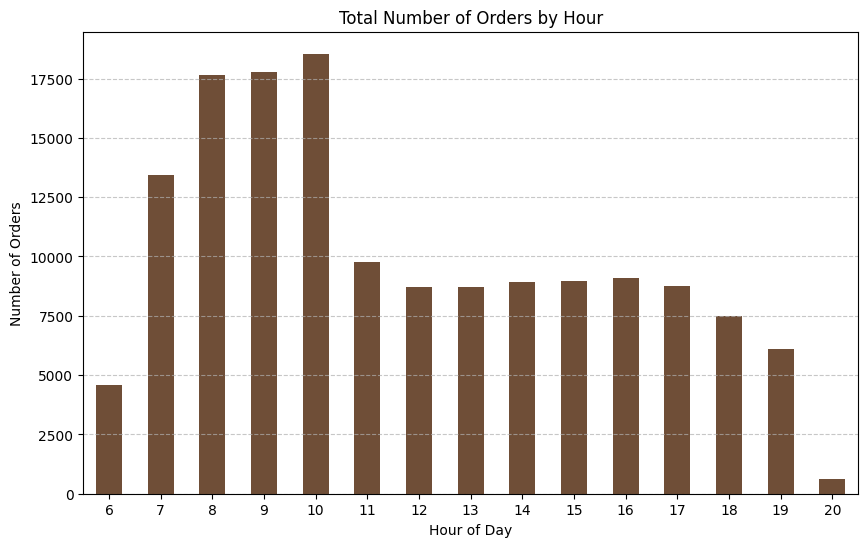

Busiest Hours (Order Counts):
transaction_hour
10    18545
9     17764
8     17654
Name: basket_id, dtype: int64


In [25]:
# group by hour and count transaction
hourly_counts = df.groupby("transaction_hour")["basket_id"].count()

# plot bar chart
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind="bar", color="#6f4e37")  # use coffee color

plt.title("Total Number of Orders by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# print out top 3 hours
print("Busiest Hours (Order Counts):")
print(hourly_counts.sort_values(ascending=False).head(3))

Peak Trading Hours Anlayisis

Observation: 
As illustrated in the bar chart, sales volume is heavily concentrated in the morning hours. The peak trading period occurs between 8:00AM and 10:00AM, with the highest volume at 10:00AM (average about 102 transactions).

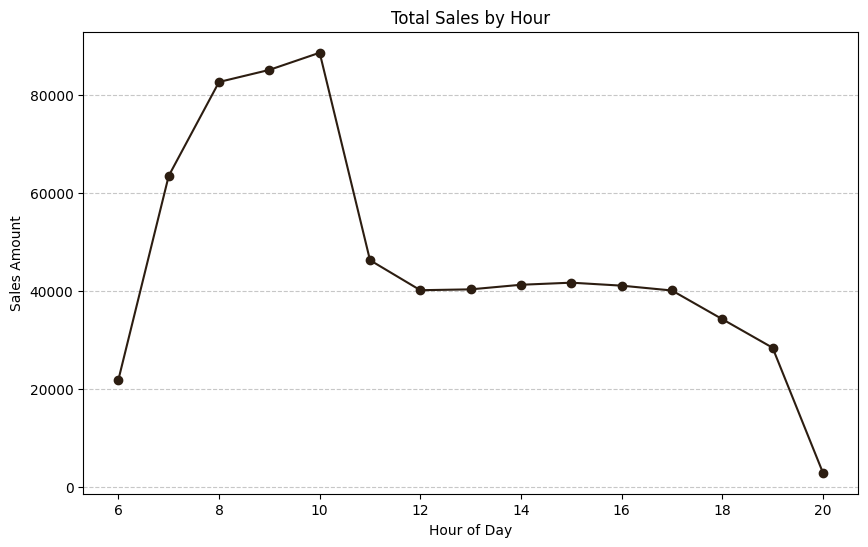

Highest Revenue Hours:
transaction_hour
10    88673.39
9     85169.53
8     82699.87
Name: sales, dtype: float64


In [26]:
# group by hour and count transaction
hourly_sales = df.groupby("transaction_hour")["sales"].sum()

# plot bar chart
plt.figure(figsize=(10, 6))
hourly_sales.plot(kind="line", color="#2c1d11", marker="o")  # use coffee color

plt.title("Total Sales by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Sales Amount")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# print out top 3 hours
print("Highest Revenue Hours:")
print(hourly_sales.sort_values(ascending=False).head(3))

Even though morning are the peak hours, but afternoon still creates about half of revenue of the peak hours.

# 5. Store/Region Performance

In [29]:
# 2. 重新聚合数据 (Group by Store)
new_store_perf = df.groupby("store_location").agg(
    total_revenue=("sales", "sum"),  # 总销售额（不变）
    total_items_sold=("transaction_qty", "sum"),  # 总销量（不变）
    order_count=("basket_id", "nunique"),  # 【变化点】真实的单量
)

# 3. 计算真实的 KPI
new_store_perf["AOV"] = new_store_perf["total_revenue"] / new_store_perf["order_count"]
new_store_perf["UPT"] = (
    new_store_perf["total_items_sold"] / new_store_perf["order_count"]
)

# 4. 排序并展示
new_store_perf = new_store_perf.sort_values(by="total_revenue", ascending=False)

# 格式化展示
print("📊 RECALCULATED Store Performance (Based on Baskets):")
print("-" * 60)
print(new_store_perf[["total_revenue", "order_count", "AOV", "UPT"]])

# 5. 看看原本的数据被“压缩”了多少？
# (用来验证有多少单子其实是连带购买)
# 之前的总单量大约是 149,116 (50k+50k+47k)
original_count = 149116
new_count = new_store_perf["order_count"].sum()
ratio = original_count / new_count
print("-" * 60)
print(
    f"📉 Order Volume Correction: Traffic dropped from {original_count:,} to {new_count:,}"
)

📊 RECALCULATED Store Performance (Based on Baskets):
------------------------------------------------------------
                 total_revenue  order_count       AOV       UPT
store_location                                                 
Hell's Kitchen       236511.17        40454  5.846422  1.773298
Astoria              232243.91        40684  5.708483  1.744937
Lower Manhattan      230057.25        35652  6.452857  2.012285
------------------------------------------------------------
📉 Order Volume Correction: Traffic dropped from 149,116 to 116,790


Lower Manhattan has the highest UPT, higher than other 2 stores. How did this 2.0 UPT come from? Do customers buy more than 1 drink or grabed food with the drink?

# 6. Product Category & Type Performance

In [32]:
# 1. Group by Category and Type, then sum Sales
revenue_analysis = df.groupby(["product_category"])["sales"].sum().reset_index()

# 2. Sort by Sales in descending order
top_performers = revenue_analysis.sort_values(by="sales", ascending=False)

# 3. Calculate Cumulative Percentage
total_revenue = top_performers["sales"].sum()
top_performers["revenue_share"] = top_performers["sales"] / total_revenue

# 4. Display the top 10 results
# Format sales for better readability
display_df = top_performers.copy()
display_df["sales"] = display_df["sales"].apply(lambda x: "${:,.2f}".format(x))
display_df["revenue_share"] = display_df["revenue_share"].apply(
    lambda x: "{:.2%}".format(x)
)

print(display_df[["product_category", "sales", "revenue_share"]].head(5))

     product_category        sales revenue_share
2              Coffee  $269,952.45        38.63%
8                 Tea  $196,405.95        28.11%
0              Bakery   $82,315.64        11.78%
4  Drinking Chocolate   $72,416.00        10.36%
3        Coffee beans   $40,085.25         5.74%


Coffee is the dominant category, accounting for nearly 39% of total revenue, followed by tea at 28%. These tow together make up over 2/3 of total sales, indicating that beverages are the primary revenue drivers.

In [30]:
# 1. create pivot talbe: to check total quantity of each catergory by store location
category_pivot = df.pivot_table(
    index="product_category",
    columns="store_location",
    values="transaction_qty",
    aggfunc="sum",
)

# 2. calculate category percentage by store
# axis=0 means sum by column, div means division
category_mix = category_pivot.div(category_pivot.sum(axis=0), axis=1)

print("=== Total Quantity by Category ===")
print(category_pivot)
print("\n=== Percentage Mix by Store ===")
print(category_mix)

=== Total Quantity by Category ===
store_location      Astoria  Hell's Kitchen  Lower Manhattan
product_category                                            
Bakery                 7496            7678             8040
Branded                 279             119              378
Coffee                29655           30220            29375
Coffee beans            502             790              536
Drinking Chocolate     6351            5672             5434
Flavours               2206            3596             4709
Loose Tea               344             485              381
Packaged Chocolate      110             197              180
Tea                   24048           22980            22709

=== Percentage Mix by Store ===
store_location       Astoria  Hell's Kitchen  Lower Manhattan
product_category                                             
Bakery              0.105591        0.107030         0.112068
Branded             0.003930        0.001659         0.005269
Coffee       

In [31]:
# [Cell: Category & Product Type Analysis]

# 1. Data Aggregation (Replaces previous manual groupby steps)
# We aggregate directly from the clean 'df' to get the necessary granularity.
plot_df = df.groupby(["product_category", "product_type"], as_index=False)[
    "sales"
].sum()

# 2. Metric Calculation
# Calculate total revenue once to use for shares.
total_revenue = plot_df["sales"].sum()

# Use 'transform' to add category-level totals directly to the dataframe.
# This eliminates the need for a separate 'cat_totals' dataframe and merging.
plot_df["category_total"] = plot_df.groupby("product_category")["sales"].transform(
    "sum"
)
plot_df["cat_share"] = plot_df["category_total"] / total_revenue
plot_df["type_share"] = plot_df["sales"] / total_revenue

# 3. Filter Top 5 Categories
# Logic: Find unique categories with the highest sales using the pre-calculated 'category_total'.
top_5_cats = (
    plot_df[["product_category", "category_total"]]
    .drop_duplicates()
    .nlargest(5, "category_total")
)
plot_df_filtered = plot_df[
    plot_df["product_category"].isin(top_5_cats["product_category"])
].copy()

# 4. Interactive Visualization
import plotly.express as px

fig = px.bar(
    plot_df_filtered,
    x="sales",
    y="product_category",
    color="product_type",
    orientation="h",
    title="<b>Revenue Breakdown by Category & Type</b><br><sup>Top 5 categories contribute the most to total revenue</sup>",
    hover_data={
        "product_category": False,
        "product_type": True,
        "sales": ":,.0f",
        "type_share": ":.2%",
        "cat_share": ":.1%",
    },
    labels={"sales": "Revenue ($)", "cat_share": "Category Share"},
)

fig.update_layout(
    yaxis={"categoryorder": "total ascending"}, template="plotly_white", height=500
)
fig.show()

In [ ]:
# 1. Group by Category and Type, then sum Sales
revenue_analysis = (
    df.groupby(["product_category", "product_type"])["sales"].sum().reset_index()
)

# 2. Sort by Sales in descending order
top_performers = revenue_analysis.sort_values(by="sales", ascending=False)

# 3. Calculate Cumulative Percentage
total_revenue = top_performers["sales"].sum()
top_performers["revenue_share"] = top_performers["sales"] / total_revenue

# 4. Display the top 10 results
# Format sales for better readability
display_df = top_performers.copy()
display_df["sales"] = display_df["sales"].apply(lambda x: "${:,.2f}".format(x))
display_df["revenue_share"] = display_df["revenue_share"].apply(
    lambda x: "{:.2%}".format(x)
)

print(
    display_df[["product_category", "product_type", "sales", "revenue_share"]].head(10)
)

      product_category           product_type       sales revenue_share
5               Coffee       Barista Espresso  $91,406.20        13.08%
26                 Tea        Brewed Chai tea  $77,081.95        11.03%
16  Drinking Chocolate          Hot chocolate  $72,416.00        10.36%
7               Coffee  Gourmet brewed coffee  $70,034.60        10.02%
25                 Tea       Brewed Black tea  $47,932.00         6.86%
28                 Tea      Brewed herbal tea  $47,539.50         6.80%
9               Coffee  Premium brewed coffee  $38,781.15         5.55%
8               Coffee  Organic brewed coffee  $37,746.50         5.40%
2               Bakery                  Scone  $36,866.12         5.28%
6               Coffee            Drip coffee  $31,984.00         4.58%


# 7. Best-Selling Products

In [33]:
# 1. 定义提取规则
# 逻辑：找结尾是 Sm, Rg, Lg 的单词
# \s+ 表示前面的空格
# (Sm|Rg|Lg) 表示这三个尺寸之一
# $ 表示字符串结尾
size_pattern = r"\s+(Sm|Rg|Lg)$"

# 2. 拆分：提取 Size
df["Size"] = df["product_detail"].str.extract(size_pattern, expand=False)

# 3. 清洗：把 Size 从原名字里删掉，得到干净的 Base Name
# 比如 "Latte Rg" -> "Latte"
df["Product_Base"] = (
    df["product_detail"].str.replace(size_pattern, "", regex=True).str.strip()
)

# 4. 填充空值 (Optional)
# 比如原本就是 "Latte" 的，提取出来 Size 是 NaN，我们可以填成 "Rg" 或者 "Unknown"
df["Size"] = df["Size"].fillna("Unknown")  # 如果你认为没标就是 Regular

# 5.重新聚合：见证真正的榜单 (True Best Sellers)
true_ranking = (
    df.groupby("Product_Base")["transaction_qty"].sum().sort_values(ascending=False)
)

print("🏆 TRUE Best Sellers (Combined Sizes):")
print("-" * 50)
print(true_ranking.head(15))

# 6. 顺便看看每种产品的尺寸偏好 (Size Preference)
print("\n📏 Size Preference Breakdown (Top 5 Products):")
print("-" * 50)
top_5_products = true_ranking.head(5).index
size_breakdown = (
    df[df["Product_Base"].isin(top_5_products)]
    .groupby(["Product_Base", "Size"])["transaction_qty"]
    .sum()
)
size_breakdown

🏆 TRUE Best Sellers (Combined Sizes):
--------------------------------------------------
Product_Base
Ethiopia                     13271
Our Old Time Diner Blend     13074
Columbian Medium Roast       13068
Brazilian                    13012
Jamaican Coffee River        12431
Morning Sunrise Chai          9157
Latte                         9099
Earl Grey                     9095
Peppermint                    9067
Sustainably Grown Organic     9003
Serenity Green Tea            8856
Traditional Blend Chai        8839
Dark chocolate                8793
Spicy Eye Opener Chai         8697
English Breakfast             8670
Name: transaction_qty, dtype: int64

📏 Size Preference Breakdown (Top 5 Products):
--------------------------------------------------


Product_Base              Size   
Brazilian                 Lg         4317
                          Rg         4385
                          Sm         4310
Columbian Medium Roast    Lg         4195
                          Rg         4547
                          Sm         4178
                          Unknown     148
Ethiopia                  Lg         4227
                          Rg         4393
                          Sm         4433
                          Unknown     218
Jamaican Coffee River     Lg         4395
                          Rg         4018
                          Sm         4018
Our Old Time Diner Blend  Lg         3997
                          Rg         4410
                          Sm         4484
                          Unknown     183
Name: transaction_qty, dtype: int64